In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/minor_project

archive.zip  m.ipynb  replicated.zip  Resnet_inception_C1.ipynb


In [3]:
!unzip -qq 'drive/MyDrive/minor_project/archive.zip' -d 'dataset/'

In [4]:
!ls dataset

auto_test  test  train	val


In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import timeit
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix)
import cv2

In [6]:
np.random.seed(10340)

In [7]:
def get_classes(data_path, classes, data):
    print(f"---- {data} ----")
    knee_severity = {}
    count = 0

    for i in range(len(classes)):
        imgs = os.listdir(os.path.join(data_path, str(i)))
        knee_severity[i] = imgs
        count += len(imgs)

    for k, v in knee_severity.items():
        print(
            f"Grade {k} - {classes[k]}: {len(v)} images, {round((len(v) * 100) / count, 2)}%"
        )

    return knee_severity


def plot_classes(dict_classes, data_path, classes, data):
    for k, v in dict_classes.items():
        print(f"{data} - {classes[k]}")
        plt.figure(figsize=(10, 25))
        for i in range(5):
            img_path = os.path.join(data_path, str(k), v[i])
            img = tf.keras.preprocessing.image.load_img(img_path)
            plt.subplot(1, 5, 1 + i, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f"Grade {k}")
        plt.show()

In [46]:
model_name="Inception_ResNet_V2"

target_size=(224, 224)
epochs=40
batch_size=256
img_shape=(224, 224, 3)

save_model_ft=os.path.join('models', f'model_{model_name}_ft.h5')

In [9]:
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

In [10]:
base_dir="dataset/"
train_path=os.path.join(base_dir, 'train')
valid_path=os.path.join(base_dir, 'val')
test_path=os.path.join(base_dir, 'test')

In [11]:
train_data = get_classes(train_path, class_names, 'Train')
valid_data = get_classes(valid_path, class_names, 'Valid')
tests_data = get_classes(test_path, class_names, 'Test')

---- Train ----
Grade 0 - Healthy: 2286 images, 39.56%
Grade 1 - Doubtful: 1046 images, 18.1%
Grade 2 - Minimal: 1516 images, 26.24%
Grade 3 - Moderate: 757 images, 13.1%
Grade 4 - Severe: 173 images, 2.99%
---- Valid ----
Grade 0 - Healthy: 328 images, 39.71%
Grade 1 - Doubtful: 153 images, 18.52%
Grade 2 - Minimal: 212 images, 25.67%
Grade 3 - Moderate: 106 images, 12.83%
Grade 4 - Severe: 27 images, 3.27%
---- Test ----
Grade 0 - Healthy: 639 images, 38.59%
Grade 1 - Doubtful: 296 images, 17.87%
Grade 2 - Minimal: 447 images, 26.99%
Grade 3 - Moderate: 223 images, 13.47%
Grade 4 - Severe: 51 images, 3.08%


Train data - Healthy


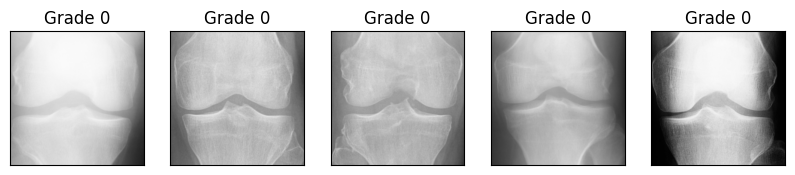

Train data - Doubtful


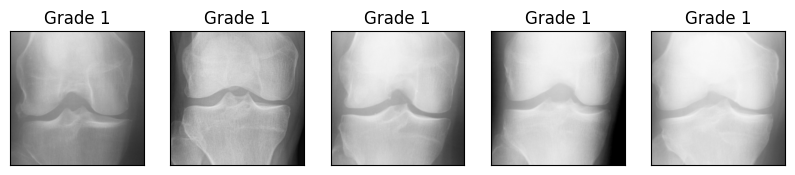

Train data - Minimal


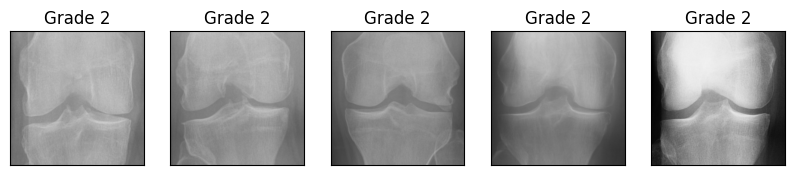

Train data - Moderate


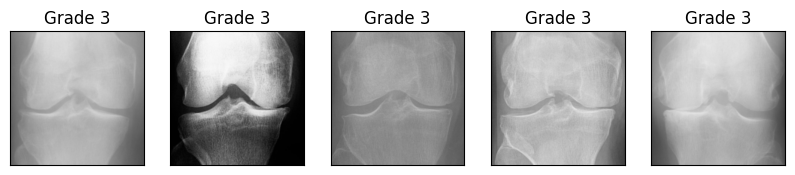

Train data - Severe


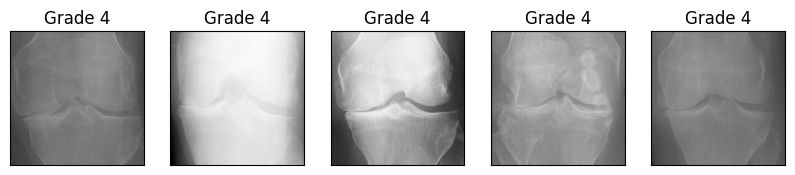

In [12]:
plot_classes(train_data, train_path, class_names, 'Train data')

Valid data - Healthy


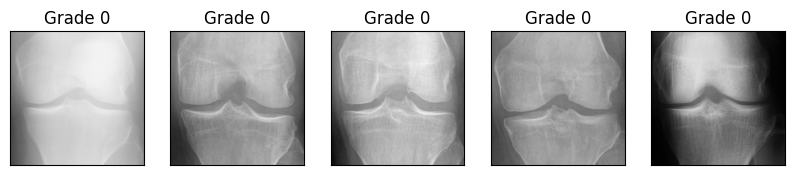

Valid data - Doubtful


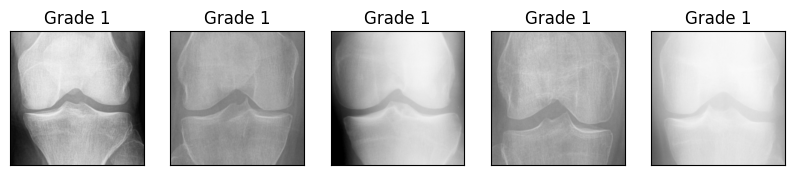

Valid data - Minimal


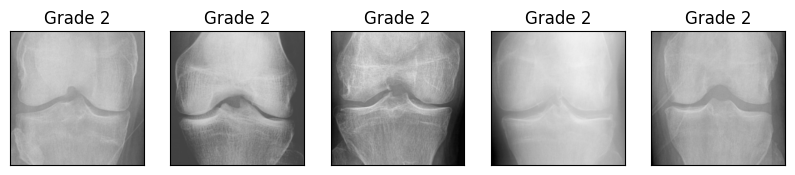

Valid data - Moderate


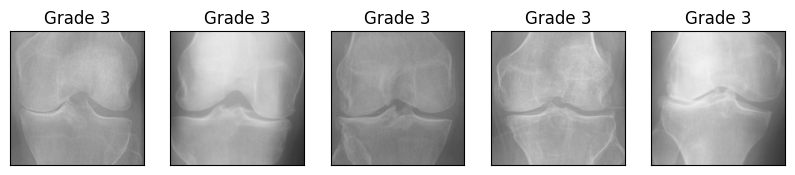

Valid data - Severe


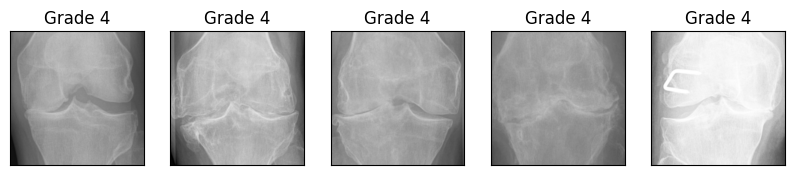

In [13]:
plot_classes(valid_data, valid_path, class_names, 'Valid data')

Test data - Healthy


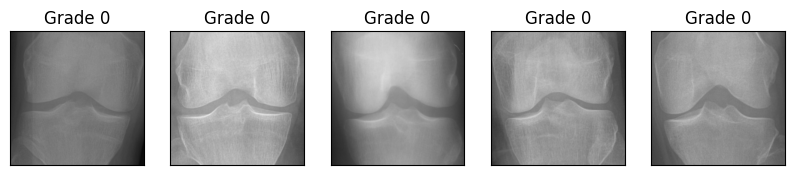

Test data - Doubtful


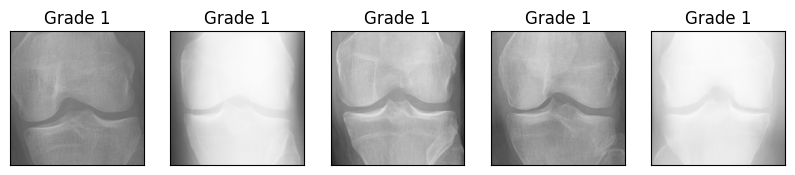

Test data - Minimal


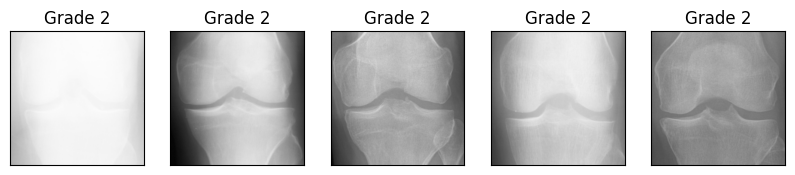

Test data - Moderate


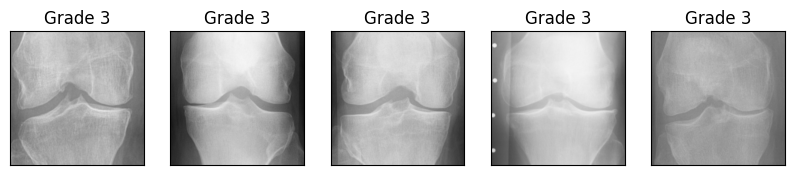

Test data - Severe


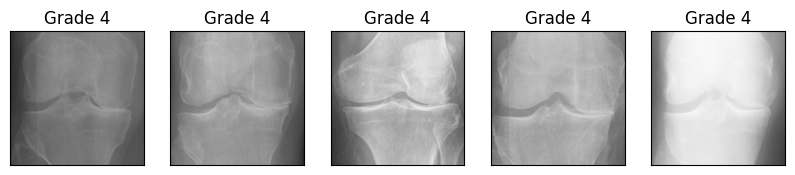

In [14]:
plot_classes(tests_data, test_path, class_names, 'Test data')

In [15]:
def get_plot_loss_acc(model, model_name):
    fig=plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()

def compute_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm=confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )
    cmn=cm.astype("float")/cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

def get_evaluate(data, name, model):
    score_model=model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]: .2f}")
    print(f"{name} accuracy: {score_model[1]: .2f}")

def get_predict(data, model):
    predict_model=model.predict(data)
    return predict_model

def get_metrics(y_test, y_pred, model_name):
    acc=accuracy_score(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc: .2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc: .2f}")
    print("\n")

    print(classification_report(y_test, y_pred))


Found 5778 images belonging to 5 classes.


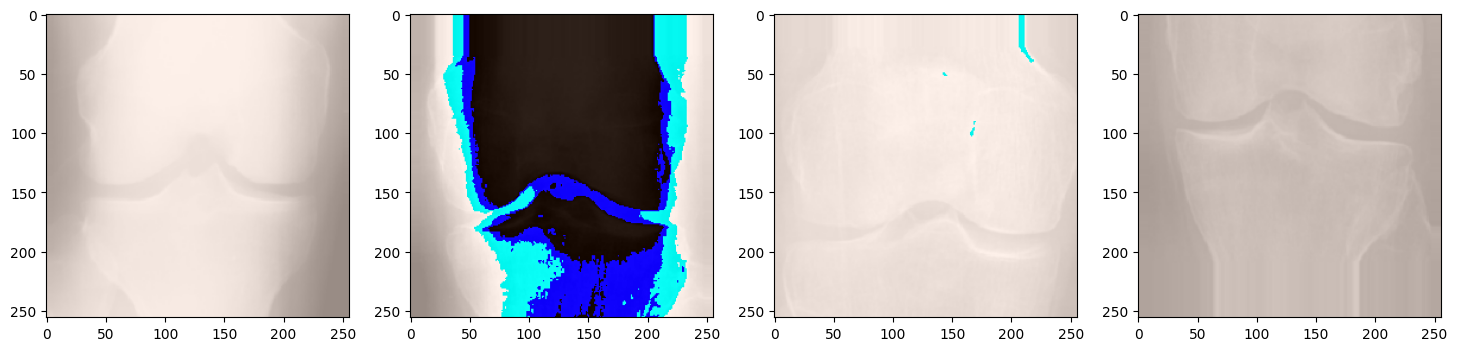

In [66]:
datagen=tf.keras.preprocessing.image.ImageDataGenerator(
  preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)
imagegen=datagen.flow_from_directory(train_path, batch_size=1)
fig, rows=plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for row in rows:
    row.imshow(imagegen.next()[0][0].astype("uint8"))
plt.show()

In [17]:

aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

In [18]:

train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)



Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [19]:
y_train=train_generator.labels
y_val=valid_generator.labels

In [20]:

unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)


Train:  {0: 2286, 1: 1046, 2: 1516, 3: 757, 4: 173}
{0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}


In [21]:
classes = np.unique(y_train)

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.01, patience=8,
            restore_best_weights=True
        )
plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.1, min_delta=0.01,
                min_lr=1e-10, patience=4, mode='auto'
            )

In [22]:
model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

219055592/219055592 [==============================] - 1s 0us/step


In [23]:
for layer in model.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)

model_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 5)                 7685      
                                                                 
Total params: 54344421 (207.31 MB)
Trainable params: 54283877 (207.08 MB)
Non-trainable params: 60544 (236.50 KB)
_________________________________________________________________


In [24]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/40
181/181 [==============================] - 253s 788ms/step - loss: 1.2584 - accuracy: 0.3956 - val_loss: 1.3317 - val_accuracy: 0.4383
Epoch 2/40
181/181 [==============================] - 131s 723ms/step - loss: 0.9386 - accuracy: 0.5339 - val_loss: 1.0689 - val_accuracy: 0.5339
Epoch 3/40
181/181 [==============================] - 133s 732ms/step - loss: 0.8831 - accuracy: 0.5633 - val_loss: 2.0805 - val_accuracy: 0.3777
Epoch 4/40
181/181 [==============================] - 131s 725ms/step - loss: 0.8389 - accuracy: 0.5794 - val_loss: 3.1713 - val_accuracy: 0.5012
Epoch 5/40
181/181 [==============================] - 131s 720ms/step - loss: 0.7721 - accuracy: 0.6139 - val_loss: 7.9954 - val_accuracy: 0.1889
Epoch 6/40
181/181 [==============================] - 132s 726ms/step - loss: 0.7682 - accuracy: 0.6137 - val_loss: 2.2250 - val_accuracy: 0.3366
Epoch 7/40
181/181 [==============================] - 130s 720ms/step - loss: 0.7431 - accuracy: 0.6244 - val_loss: 1.1113 -

In [25]:

execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model {model_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)


Model Inception_ResNet_V2 fine tuning executed in 98.65 minutes


In [47]:
model_ft.save(save_model_ft)

KeyError: ignored

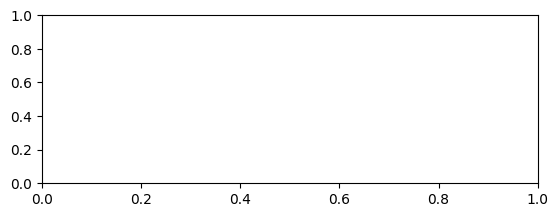

In [48]:
get_plot_loss_acc(model_ft, f"{model_name} Fine Tuning")

In [30]:
get_evaluate(valid_generator, "Valid", model_ft)

26/26 [==============================] - 5s 165ms/step - loss: 1.4873 - accuracy: 0.5533
Valid loss:  1.49
Valid accuracy:  0.55


In [31]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

26/26 [==============================] - 9s 166ms/step
Accuracy Score - Inception_ResNet_V2:  0.55
Balanced Accuracy Score - Inception_ResNet_V2:  0.60


              precision    recall  f1-score   support

           0       0.78      0.50      0.61       328
           1       0.21      0.09      0.13       153
           2       0.44      0.85      0.58       212
           3       0.69      0.70      0.69       106
           4       0.74      0.85      0.79        27

    accuracy                           0.55       826
   macro avg       0.57      0.60      0.56       826
weighted avg       0.58      0.55      0.53       826



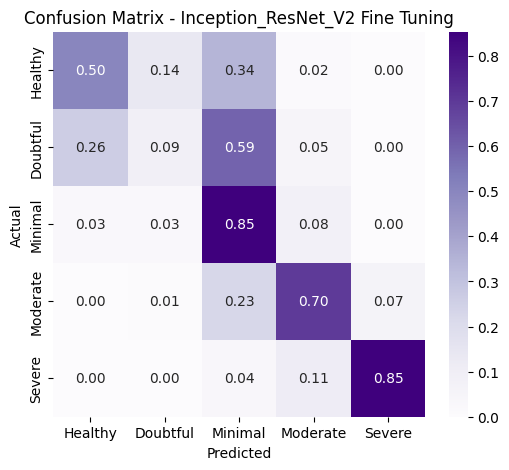

In [32]:

compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)

In [33]:
test_generator = noaug_datagen.flow_from_directory(
    test_path,
    batch_size=batch_size,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 1656 images belonging to 5 classes.


In [34]:
y_test = test_generator.labels


In [53]:
get_evaluate(test_generator, "Test", model_ft)


7/7 [==============================] - 25s 2s/step - loss: 1.2419 - accuracy: 0.6141
Test loss:  1.24
Test accuracy:  0.61


In [54]:
test_model_ft=get_predict(test_generator, model_ft)

get_metrics(
    test_generator.labels,
    y_pred=np.argmax(test_model_ft, axis=1),
    model_name=model_name
)

7/7 [==============================] - 9s 1s/step
Accuracy Score - Inception_ResNet_V2:  0.61
Balanced Accuracy Score - Inception_ResNet_V2:  0.65


              precision    recall  f1-score   support

           0       0.84      0.57      0.68       639
           1       0.31      0.17      0.22       296
           2       0.48      0.83      0.61       447
           3       0.77      0.84      0.81       223
           4       0.81      0.86      0.84        51

    accuracy                           0.61      1656
   macro avg       0.65      0.65      0.63      1656
weighted avg       0.64      0.61      0.60      1656



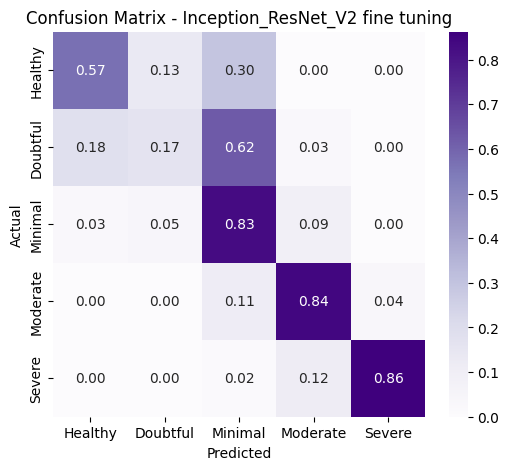

In [55]:
compute_confusion_matrix(
    test_generator,
    test_model_ft ,
    class_names,
    f"{model_name} fine tuning",
)

In [56]:
def make_gradcam_heatmap(grad_model, img_array, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(
        superimposed_img
    )

    return superimposed_img


In [57]:
tests_data = get_classes(test_path, class_names, 'test')

---- test ----
Grade 0 - Healthy: 639 images, 38.59%
Grade 1 - Doubtful: 296 images, 17.87%
Grade 2 - Minimal: 447 images, 26.99%
Grade 3 - Moderate: 223 images, 13.47%
Grade 4 - Severe: 51 images, 3.08%


In [59]:
conv_output = model_ft.get_layer("global_average_pooling2d").input

grad_model = tf.keras.models.Model(
    [model_ft.inputs], [conv_output, model_ft.output]
)

# model
model_ft.layers[-1].activation = None


Test data - Healthy


<ipython-input-56-393f033ac686>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


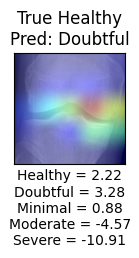

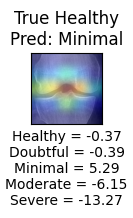

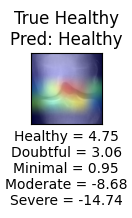

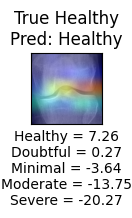

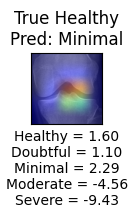

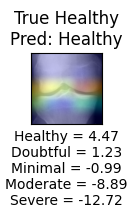

Test data - Doubtful


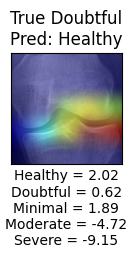

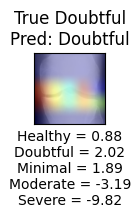

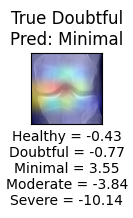

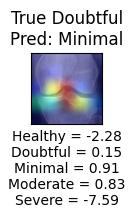

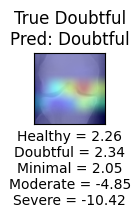

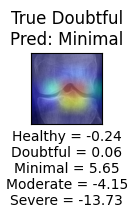

Test data - Minimal


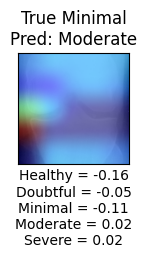

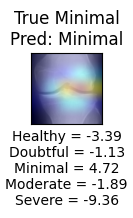

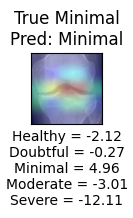

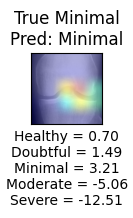

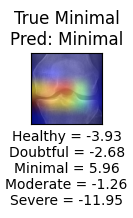

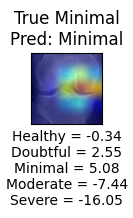

Test data - Moderate


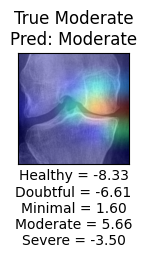

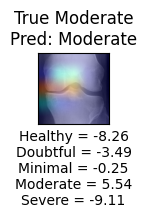

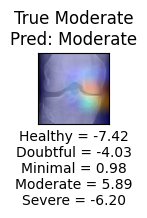

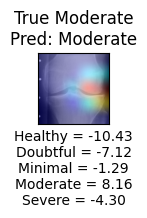

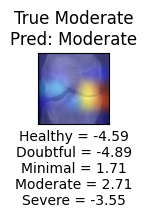

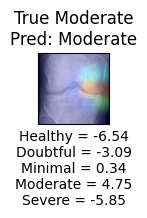

Test data - Severe


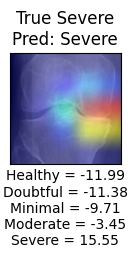

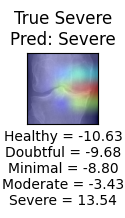

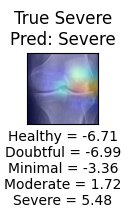

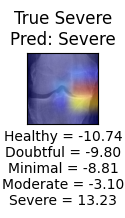

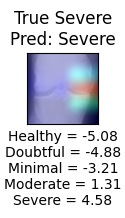

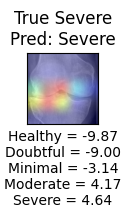

In [64]:
for k, v in tests_data.items():
    print(f"Test data - {class_names[k]}")
    plt.figure(figsize=(10, 28))
    for i in range(6):
        img_path = os.path.join(test_path, str(k), v[i])
        # prepare image
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=target_size
        )
        img = tf.keras.preprocessing.image.img_to_array(img)

        img_aux = img.copy()
        img_array = np.expand_dims(img_aux, axis=0)
        img_array = np.float32(img_array)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

        y_pred = model_ft.predict(img_array, verbose=0)[0]

        heatmap = make_gradcam_heatmap(grad_model, img_array)
        image = save_and_display_gradcam(img, heatmap)

        plt.subplot(1, 6, 1 + i, xticks=[], yticks=[])
        plt.imshow(image)
        plt.title(
            f"True {class_names[k]}\nPred: {class_names[np.argmax(y_pred)]}"
        )
        plt.xlabel(
            "\n".join([f"{c} = {p:.2f}" for c, p in zip(class_names, y_pred)])
        )
        plt.show()